# 计算不同特征的PSI值，比较它们的稳定性

In [1]:
from __future__ import division
import math
import numpy as np

import pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# 1. 读数据

- data_clean.csv是1_preprocess处理后的数据
    - 每行都表示一个借款账户
    - issue_d表示申请贷款的月份
- LCDataDictionary.csv是Leng Club数据中的变量含义
- Completeness.csv是各变量缺失比例的数据
- Effectiveness.csv是各变量KS和IV的数据

In [2]:
df = pd.read_csv('../data/data_clean.csv')
month_max = max(df.issue_d)
print '一共'+str(month_max)+'个月的数据'
df.head(3)

一共12个月的数据


,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status,issue_d
0,35000,128000.0,6.46,0,685,689,0,46.0,NaN,17,...,91.3,33.3,0,0,220950,49644,26800,71700,0,12
1,16000,70000.0,26.40,0,720,724,0,NaN,NaN,13,...,100.0,60.0,0,0,309638,62407,45900,45838,0,12
2,10000,85000.0,13.07,0,685,689,1,NaN,106.0,14,...,95.7,28.6,1,0,61099,27957,16400,30799,0,12


In [3]:
dict_df = pd.read_csv('../data/LCDataDictionary_clean.csv')
dict_df = dict_df.set_index('feature')
dict_df.head(3)

,Description
feature,
acc_now_delinq,The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan application


In [4]:
comp_df = pd.read_csv('../output/Completeness.csv')
comp_df = comp_df.set_index('feature')
comp_df.head(3)

,nan_ratio
feature,
loan_amnt,0.0
annual_inc,0.0
dti,0.0


In [5]:
effe_df = pd.read_csv('../output/Effectiveness.csv')
effe_df = effe_df.set_index('feature')
effe_df.head(3)

,KS,IV
feature,,
loan_amnt,0.020218,0.004140
annual_inc,0.041286,0.021428
dti,0.076777,0.048852


# 2. 计算tot_cur_bal特征在1月和6月的PSI值

In [6]:
df_temp = df[['issue_d','tot_cur_bal']]
df_temp = df_temp[df_temp['issue_d'].isin([1,6])]
before_total = df_temp[df_temp['issue_d']==1].shape[0]
after_total = df_temp[df_temp['issue_d']==6].shape[0]
total = before_total + after_total
print '1月数据条数：', before_total
print '6月数据条数：', after_total

1月数据条数： 35107
6月数据条数： 28485


## 如果存在缺失值，则将没有tot_cur_bal特征的数据单独归为一组，计算其psi

In [7]:
df_null_index = np.isnan(df_temp['tot_cur_bal'])
df_null = df_temp.ix[df_null_index]
if len(df_null) > 0:
    before_in_bin = len(df_null[df_null['issue_d']==before_time])
    after_in_bin = len(df_null[df_null['issue_d']==after_time])
    befor_ratio_in_bin = before_in_bin / before_total + 0.01
    after_ratio_in_bin = after_in_bin / after_total + 0.01
    PSI  = (befor_ratio_in_bin - after_ratio_in_bin) * math.log(befor_ratio_in_bin / after_ratio_in_bin)
    total_no_nan = total - before_in_bin -after_in_bin
else:
    PSI = 0
    total_no_nan = total

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


## 去除缺失值后按照tot_cur_bal对数据进行排序和分组

- 要求
    - 每组都至少有10%的用户（最后一组例外）
    - 同一score的账户必须分入同一组

In [8]:
df_temp.dropna(how='any')
df_temp = df_temp.sort_values(by='tot_cur_bal')
df_temp = df_temp.reset_index(level=0, drop=True)

In [9]:
bin_size = int(math.ceil(total_no_nan * 0.1))

bins = []  # 记录每组最后一个账户

num_bins = 0

i = 0
start_index = 0
while i < total_no_nan:

    end_index = start_index + bin_size - 1
    if end_index >= total_no_nan - 1:
    # 最后一组，直接分组
        end_index = total_no_nan - 1
    else:
    # 非最后一组，查看当前组内最后一个账户，是否与下个账户tot_coll_amt特征值相同。如果相同，则将下个账户分入当前组
        while end_index + 1 <= total_no_nan - 1 and df_temp.ix[end_index]['tot_cur_bal'] == df_temp.ix[end_index + 1]['tot_cur_bal']:
            end_index = end_index + 1

    bins.append(end_index)
    num_bins = num_bins + 1

    start_index = end_index + 1
    i = end_index + 1

print '每组最后一个账户的ID分别是: '
print bins

每组最后一个账户的ID分别是: 
[6359, 12720, 19080, 25441, 31801, 38161, 44521, 50881, 57241, 63591]


/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


## 计算PSI值

In [10]:
start_index = 0

i = 0
while i < num_bins:
    s1 = df_temp[start_index:(bins[i] + 1)]
    s2 = s1[s1['issue_d'] == 1]
    s3 = s1[s1['issue_d'] == 6]

    before_in_bin = s2.index.size 
    after_in_bin = s3.index.size

    befor_ratio_in_bin = before_in_bin / before_total + 0.01
    after_ratio_in_bin = after_in_bin / after_total + 0.01

    psi = (befor_ratio_in_bin - after_ratio_in_bin) * math.log(befor_ratio_in_bin / after_ratio_in_bin)
    PSI= PSI + psi

    start_index = bins[i] + 1
    i= i + 1


print 'PSI: ', PSI

PSI:  0.00119986886716


# 2. 计算所有特征的PSI值，依次让2月同1月对比，3月同1月对比...12月同1月对比

In [11]:
def get_PSI(time,feature):
    """time and feature are both lists.
       return the PSI value.
    """
    df_temp = pd.DataFrame(zip(time,feature),columns=['issue_d','feature_score'])
    issue_d_values = sorted(list(set(time)))
    before_time = issue_d_values[0]
    after_time = issue_d_values[1]
    before_total = df_temp[df_temp['issue_d']==before_time].shape[0]
    after_total = df_temp[df_temp['issue_d']==after_time].shape[0]
    total = before_total + after_total
    
    df_null_index = np.isnan(df_temp['feature_score'])
    df_null = df_temp.ix[df_null_index]
    if len(df_null) > 0:
        before_in_bin = len(df_null[df_null['issue_d']==before_time])
        after_in_bin = len(df_null[df_null['issue_d']==after_time])
        befor_ratio_in_bin = before_in_bin / before_total + 0.01
        after_ratio_in_bin = after_in_bin / after_total + 0.01
        PSI  = (befor_ratio_in_bin - after_ratio_in_bin) * math.log(befor_ratio_in_bin / after_ratio_in_bin)
        total_no_nan = total - before_in_bin -after_in_bin
    else:
        PSI = 0
        total_no_nan = total
    
    df_temp = df_temp.dropna(how='any')
    df_temp = df_temp.sort_values(by='feature_score')
    df_temp = df_temp.reset_index(level=0, drop=True)

    
    bin_size = int(math.ceil(total_no_nan * 0.1))

    bins = []  # 记录每组最后一个账户
    num_bins = 0

    i = 0
    start_index = 0
    while i < total_no_nan:

        end_index = start_index + bin_size - 1
        if end_index >= total_no_nan - 1:
        # 最后一组，直接分组
            end_index = total_no_nan - 1
        else:
        # 非最后一组，查看当前组内最后一个账户，是否与下个账户feature_score特征值相同。如果相同，则将下个账户分入当前组
            while end_index + 1 <= total_no_nan - 1 and df_temp.ix[end_index]['feature_score'] == df_temp.ix[end_index + 1]['feature_score']:
                end_index = end_index + 1

        bins.append(end_index)
        num_bins = num_bins + 1

        start_index = end_index + 1
        i = end_index + 1
        
    start_index = 0
    PSI = 0
    i = 0
    
    while i < num_bins:
        s1 = df_temp[start_index:(bins[i] + 1)]
        s2 = s1[s1['issue_d'] == before_time]
        s3 = s1[s1['issue_d'] == after_time]

        before_in_bin = s2.index.size 
        after_in_bin = s3.index.size

        befor_ratio_in_bin = before_in_bin / before_total + 0.01
        after_ratio_in_bin = after_in_bin / after_total + 0.01

        psi = (befor_ratio_in_bin - after_ratio_in_bin) * math.log(befor_ratio_in_bin / after_ratio_in_bin)
        PSI= PSI + psi

        start_index = bins[i] + 1
        i= i + 1

    return PSI



In [12]:
def get_PSI_features(time, feature_df):
    """time is a list and feature_df is a data frame.
       return the PSI values of every feature in the feature_df.
    """    
    PSI = []

    for feature in feature_df.columns:
        cur_PSI = get_PSI(time,feature_df[feature])
        PSI.append(cur_PSI)
    return PSI

##  计算PSI
- 可能耗时较长

In [13]:
PSI_list = []
before_time = 1
feature_cols = [i for i in df.columns if i not in ['issue_d','loan_status']]

### 计算各月同1月比较的PSI值

In [14]:
for after_time in range(2,month_max+1):
    cur_df = df[df['issue_d'].isin([before_time, after_time])]
    PSI_list.append(get_PSI_features(cur_df['issue_d'],cur_df[feature_cols]))
    print '完成所有特征在1月和'+str(after_time)+'月的比较'

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


完成所有特征在1月和2月的比较
完成所有特征在1月和3月的比较
完成所有特征在1月和4月的比较
完成所有特征在1月和5月的比较
完成所有特征在1月和6月的比较
完成所有特征在1月和7月的比较
完成所有特征在1月和8月的比较
完成所有特征在1月和9月的比较
完成所有特征在1月和10月的比较
完成所有特征在1月和11月的比较
完成所有特征在1月和12月的比较


### 选取部分特征查看结果

In [14]:
show_features = ['delinq_2yrs','fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_record']
dict_df.ix[show_features]

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


,Description
feature,
delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
fico_range_low,The lower boundary range the borrower's FICO at loan origination belongs to.
fico_range_high,The upper boundary range the borrower's FICO at loan origination belongs to.
inq_last_6mths,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
mths_since_last_record,The number of months since the last public record.


In [29]:
index_names = ['PSI_1_'+str(i) for i in range(2,month_max+1)]
PSI_df = pd.DataFrame(PSI_list, columns = feature_cols,index = index_names).T
PSI_df.index.name='feature'

show_df = pd.concat([comp_df.ix[show_features],effe_df.ix[show_features],PSI_df.ix[show_features]],axis=1)
show_df

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


,nan_ratio,KS,IV,PSI_1_2,PSI_1_3,PSI_1_4,PSI_1_5,PSI_1_6,PSI_1_7,PSI_1_8,PSI_1_9,PSI_1_10,PSI_1_11,PSI_1_12
feature,,,,,,,,,,,,,,
delinq_2yrs,0.000000,0.006555,0.000425,0.000878,0.000085,0.000061,0.000280,0.000236,0.000055,0.000756,0.000337,0.000291,0.000259,0.000156
fico_range_low,0.000000,0.070732,0.072710,0.001460,0.000738,0.001401,0.001388,0.003543,0.006662,0.005569,0.010008,0.007808,0.009213,0.006920
fico_range_high,0.000000,0.070732,0.072710,0.001460,0.000738,0.001401,0.001388,0.003543,0.006662,0.005569,0.010008,0.007808,0.009213,0.006920
inq_last_6mths,0.000000,0.114747,0.037908,0.001311,0.001563,0.000789,0.001212,0.002861,0.003530,0.004349,0.002033,0.001997,0.001249,0.000885
mths_since_last_record,0.823282,0.120586,0.091712,0.000431,0.000811,0.002110,0.002362,0.003114,0.007309,0.004353,0.005961,0.011012,0.010481,0.010018


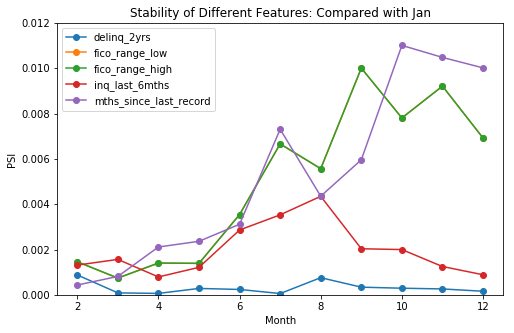

In [30]:
pylab.figure(figsize=[8,5])
for feature in show_features:
    pylab.plot(range(2,month_max+1), PSI_df.loc[feature], '-o',label=feature)
pylab.legend(loc='upper left')
pylab.ylabel("PSI")
pylab.xlabel("Month")
pylab.ylim([0,0.012])
pylab.title('Stability of Different Features: Compared with Jan')
pylab.savefig('../output/Stability_compare_with_Jan.png')

### 计算各月同上月比较的PSI值

In [18]:
PSI_list2 = []
for after_time in range(2,month_max+1):
    before_time = after_time - 1
    cur_df = df[df['issue_d'].isin([before_time, after_time])]
    PSI_list2.append(get_PSI_features(cur_df['issue_d'],cur_df[feature_cols]))
    print '完成所有特征在'+str(before_time)+'月和'+str(after_time)+'月的比较'

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


完成所有特征在1月和2月的比较
完成所有特征在2月和3月的比较
完成所有特征在3月和4月的比较
完成所有特征在4月和5月的比较
完成所有特征在5月和6月的比较
完成所有特征在6月和7月的比较
完成所有特征在7月和8月的比较
完成所有特征在8月和9月的比较
完成所有特征在9月和10月的比较
完成所有特征在10月和11月的比较
完成所有特征在11月和12月的比较


In [31]:
index_names = ['PSI_'+str(i-1)+'_'+str(i) for i in range(2,month_max+1)]
PSI_df2 = pd.DataFrame(PSI_list2, columns = feature_cols,index = index_names).T
show_df2 = pd.concat([comp_df.ix[show_features],effe_df.ix[show_features],PSI_df2.ix[show_features]],axis=1)
show_df2


/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


,nan_ratio,KS,IV,PSI_1_2,PSI_2_3,PSI_3_4,PSI_4_5,PSI_5_6,PSI_6_7,PSI_7_8,PSI_8_9,PSI_9_10,PSI_10_11,PSI_11_12
feature,,,,,,,,,,,,,,
delinq_2yrs,0.000000,0.006555,0.000425,0.000878,0.000748,0.000061,0.000150,0.000020,0.00007,0.000424,0.001026,0.000722,0.000001,0.000030
fico_range_low,0.000000,0.070732,0.072710,0.001460,0.002201,0.001290,0.000266,0.001279,0.00088,0.000787,0.001564,0.000758,0.000485,0.000472
fico_range_high,0.000000,0.070732,0.072710,0.001460,0.002201,0.001290,0.000266,0.001279,0.00088,0.000787,0.001564,0.000758,0.000485,0.000472
inq_last_6mths,0.000000,0.114747,0.037908,0.001311,0.000339,0.000222,0.000169,0.000390,0.00017,0.000190,0.000659,0.000195,0.000491,0.000759
mths_since_last_record,0.823282,0.120586,0.091712,0.000431,0.000539,0.000571,0.000361,0.000405,0.00165,0.002716,0.001301,0.002048,0.000842,0.000229


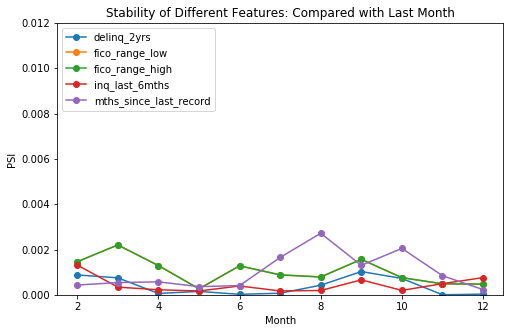

In [32]:
pylab.figure(figsize=[8,5])
for feature in show_features:
    pylab.plot(range(2,month_max+1), PSI_df2.loc[feature,], '-o',label=feature)
pylab.legend(loc='upper left')
pylab.ylabel("PSI")
pylab.xlabel("Month")
pylab.ylim([0,0.012])
pylab.title('Stability of Different Features: Compared with Last Month')
pylab.savefig('../output/Stability_compare_with_last_month.png')

## 输出结果到Stability.csv

In [21]:
stab_df = pd.concat([PSI_df,PSI_df2],axis=1)
stab_df.index_name = 'feature'
stab_df.to_csv('../output/Stability.csv')

## 合并所有结果输出到Comp_Effe_Stab.csv

In [22]:
pd.concat([dict_df.ix[feature_cols],comp_df,effe_df,stab_df], axis=1).to_csv('../output/Comp_Effe_Stab.csv')